In [104]:
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import pandas as pd
from keras import Sequential
from keras.optimizers.legacy import Adam
from keras.layers import Dense, LeakyReLU, BatchNormalization
import matplotlib.pyplot as plt


In [91]:
# define input image dimension
img_rows= 28
img_col= 28
imh_channel= 1

img_shape= (img_rows, img_col, imh_channel)

In [92]:
# noise/ latent vector -> it is nothing but the randomly generated 1D array of size 100

### Generator:

#### Given input image as noise or vector latent produces the generator produces fake image

#### for our model, it takes in 1D randomly generated noise and returns back a image by converting it into into (28,28,1) shape

In [132]:
def  build_generator():
    
    noise_shape= (100, ) # 1D array of size 100 that will be passed to the generator
    
    # for now we will be using only the simple neural network but the networks can be complicated, depends on the purpose
    # Created a Sequential model
    model= Sequential()
    
    model.add(Dense(256, input_shape= noise_shape))  # this input_shape is defined for the Sequential model's first layer (which we usually do, to pass input)
    model.add(keras.layers.LeakyReLU(alpha= 0.2))     #dont know why alpha is 0.2, taken directly from the research paper
    model.add(keras.layers.BatchNormalization(momentum= 0.8)) # momentum specifices at what rate or how fast to the model should be train
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation= 'tanh')) # it like applying activation on (z)= weights+bias -> tanh(z)
    model.add(keras.layers.Reshape(img_shape))  # Layer that reshapes inputs into the given shape.
    
    print('----------------------Build Generator - Sequential Layers--------------------------------')
    model.summary()
    
    # cerate a Functional API Model , beecause it is more flexible for non-linear problems like GAN and is more flexible.
    noise= keras.layers.Input(shape= noise_shape)  #`For Functional API model, we need to define the input layer 
    generated_img= model(noise)      # Generated image : whatever the image is generated from the Sequential model as output it to the Functional API model
    
#     print('----------------------Build Generator - Wrap Sequential Layers in Functional API--------------------------------')
    functioalApi_model= keras.models.Model(noise, generated_img)
    functioalApi_model.summary()
    
    
    return functioalApi_model# defining a functional API model
#Alpha — α is a hyperparameter It allows a small gradient when the unit is not active. It takes activation to near zero, instead of complete zero.
#Momentum — Speed up the training
    

### Descriminator:


#### Given an input image, the Discriminator outputs the likelihood of the image being real.
#### Binary classification - true or false (we're calling it validity)

#### First we flatten the image of size(28,28,1 ) to a 1D array to passin to the NN

In [131]:
def build_discriminator():
    
    model= Sequential()
    
    model.add(keras.layers.Flatten(input_shape= img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    print('----------------------Build Discriminator--------------------------------')
    model.summary()
    
    img= keras.layers.Input(shape= img_shape)
    validity= model(img)                      #The validity is the Discriminator’s guess of input being real or not.
    
#     print('----------------------Build Generator - Wrap Sequential Layers in Functional API--------------------------------')
    functioalApi_model= keras.models.Model(img, validity)
    functioalApi_model.summary()
    
    return functioalApi_model



In [124]:
# create training function

def train( epochs, batch_size=128 , save_interval= 50):
    
    # load the dataset
    (X_train, _),(_, _)= keras.datasets.mnist.load_data()
    
    # convert it to float from uint8 and normalize the data between -1 to 1 (we can also scale it to 0 to -1)
    X_train= (X_train.astype('float32')-127.5)/127.5
    
    # we will add a dimension of channel =1, as the input to our generator and desc is img of size (28,28,1)
    X_train= np.expand_dims(X_train, axis= 3)
    
    # now will divide the batch size to half, so that we can give half of the batch to training purpose 
    half_batch= int(batch_size/2)
    
    
    #We then loop through a number of epochs to train our Discriminator by first selecting
    #a random batch of images from our true dataset, generating a set of images from our
    #Generator, feeding both set of images into our Discriminator, and finally setting the
    #loss parameters for both the real and fake images, as well as the combined loss. 

    
    for epoch in range(epochs):
        
       # train the discriminator
        
        #selectthe random half batch of real images 
        idx= np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        
        # create a noise for descriminator training
        noise= np.random.normal(0, 1, (half_batch, 100))  # Draw random samples from a normal (Gaussian) distribution.
        
        # generate half batch of fake image
        gen_img= generator.predict(noise)
        
        
        # Train the discriminator on real and fake images, separately
        #Research showed that separate training is more effective. 
        d_loss_real= discriminator.train_on_batch(imgs, np.ones((half_batch,1)))   # Runs a single gradient update on a single batch of data, it returns scalar training loss
        d_loss_fake= discriminator.train_on_batch(gen_img, np.zeros((half_batch,1)))
        
        
        # take avg loss for real and fake
        d_loss= 0.5* np.add(d_loss_real,d_loss_fake)
        
        #And within the same loop we train our Generator, by setting the input noise and
        #ultimately training the Generator to have the Discriminator label its samples as valid
        #by specifying the gradient loss.
        
        # Note: When we train the descriminator, at that time we keep the generator non trainable
                # and when we train the generator, descriminator is kept non-trainable
                # we do it so that generator do not adjust the weights in descriminator
                
                
        # -------------------Train Generator----------------------
        
        #Create noise vectors as input for generator training.
        #Create as many noise vectors as defined by the batch size. 
        #Based on normal distribution. Output will be of size (batch size, 100)
        
        noise= np.random.normal( 0, 1, (batch_size, 100))
        
        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the genrator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

        
        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)

        g_loss= combined.train_on_batch(noise, valid_y)
        
        #Additionally, in order for us to keep track of our training process, we print the
        #progress and save the sample image output depending on the epoch interval specified.  
        # Plot the progress
        
        print (f"{epochs} [D loss: {d_loss[0]}, acc.: {np.round(100*d_loss[1],2)}] [G loss: {g_loss}]")
        
       

In [257]:
#######################################################################
    
# define a optimzer for easy access
optimizer= Adam(0.0002, 0.5)  #Learning rate and momentum.

# Build and compile the discriminator first. 
#Generator will be trained as part of the combined model, later. 
#pick the loss function and the type of metric to keep track.                 
#Binary cross entropy as we are doing prediction and it is a better loss function compared to MSE or other 
#for binary(0 or 1) output

discriminator= build_discriminator()
discriminator.compile(optimizer= optimizer,
                     loss= 'binary_crossentropy',
                     metrics= ['accuracy'])

print('----------------------After Building Discriminator--------------------------------')
discriminator.summary()
#build and compile our Discriminator, pick the loss function

#since we are only generating (faking) images, let us not track any metrics.
generator= build_generator()
generator.compile(optimizer= optimizer,
                loss= 'binary_crossentropy')

print('----------------------After Building Generator--------------------------------')
generator.summary()

#This builds the Generator and defines the input noise. 
#In a GAN the Generator network takes noise z as an input to produce its images.  
z= keras.layers.Input(shape= (100,))
img= generator(z)

# plt.imshow(img[0])
#This ensures that when we combine our networks we only train the Generator.
#While generator training we do not want discriminator weights to be adjusted. 
#This Doesn't affect the above descriminator training.

discriminator.trainable= False

#This specifies that our Discriminator will take the images generated by our Generator
#and true dataset and set its output to a parameter called valid, which will indicate
#whether the input is real or not.  

valid= discriminator(img)   #Validity check on the generated image



#Here we combined the models and also set our loss function and optimizer. 
#Again, we are only training the generator here. 
#The ultimate goal here is for the Generator to fool the Discriminator.  
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity

combined= keras.models.Model(z, valid) 

print('----------------------Combined Generator and Discriminator--------------------------------')
combined.summary()
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


train(epochs= 1, batch_size=32, save_interval=10)

#Save model for future use to generate fake images
#Not tested yet... make sure right model is being saved..
#Compare with GAN4

# generator.save('generator_model.h5')  #Test the model on GAN4_predict...
#Change epochs back to 30K
                
#Epochs dictate the number of backward and forward propagations, the batch_size
#indicates the number of training samples per backward/forward propagation, and the
#sample_interval specifies after how many epochs we call our sample_image function.


----------------------Build Discriminator--------------------------------
Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_111 (Dense)           (None, 512)               401920    
                                                                 
 leaky_re_lu_81 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_112 (Dense)           (None, 256)               131328    
                                                                 
 leaky_re_lu_82 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_113 (Dense)           (None, 1)                 257       
                                             

In [130]:
# x = keras.layers.Input(shape=(32,))
# y = tf.square(x)  # This op will be treated like a layer
# model = keras.models.Model(x, y)
# model.summary()
# y

In [98]:
 noise_shape= (100, ) # 1D array of size 100 that will be passed to the generator
    
# for now we will be using only the simple neural network but the networks can be complicated, depends on the purpose

model= Sequential()
model.add(Dense(256, input_shape= noise_shape))
model.add(keras.layers.LeakyReLU(alpha= 0.2))     #dont know why alpha is 0.2, taken directly from the research paper
model.add(keras.layers.BatchNormalization(momentum= 0.8)) # momentum specifices at what rate or how fast to the model should be train
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))

model.add(Dense(np.prod(img_shape), activation= 'tanh')) # it like applying activation on (z)= weights+bias -> tanh(z)
model.add(keras.layers.Reshape(img_shape))  # Layer that reshapes inputs into the given shape.

# model.summary()

# noise= keras.layers.Input(shape= noise_shape)  #`Input()` is used to instantiate a Keras tensor.
# generated_img= model(noise)      # Generated image
#           # Generated image
# print(noise)
# print("===========generated------------",generated_img)
# chit= keras.models.Model(noise, generated_img)
# print("---------------------hi", chit)
noise= np.random.normal(0, 1, (64, 100))
img= model.predict(noise)

# keras.utils.plot_model(chit, "model.png",show_shapes=True)

2/2 [==============================] - 0s 18ms/step


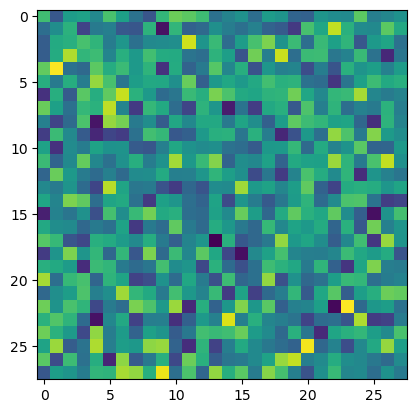

In [99]:
plt.imshow(img[0])

In [261]:
np.ones((1,))

array([1.])

In [291]:
model = Sequential()
model.add(Embedding(10, 50, embeddings_initializer="ones")) #Try "uniform" and "ones" initializer

#Array of size 10, --> should output size (10,1,50)
input_array = np.array([5])
output_array = model.predict(input_array)



1/1 [==============================] - 0s 106ms/step


In [292]:
output_array

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.]], dtype=float32)

In [277]:
layer

<KerasTensor: shape=(None, 1, 50) dtype=float32 (created by layer 'embedding_47')>